### Open Questions and To Do:
- How do we tackle unbalanced data? With weights?

In [8]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"df_total_features.csv")

# Display the first few rows
print(df.head())

# Check column names and data types
print(df.info())

   Unnamed: 0                                               file  \
0           0  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...   
1           1  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...   
2           2  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...   
3           3  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...   
4           4  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1026944...   

   is_background         date_time         location speed_kmh  sample_pos  \
0           True  2019-10-22-08-40  Fraunhofer-IDMT        30    10077440   
1           True  2019-10-22-08-40  Fraunhofer-IDMT        30    10077440   
2           True  2019-10-22-08-40  Fraunhofer-IDMT        30    10173440   
3           True  2019-10-22-08-40  Fraunhofer-IDMT        30    10173440   
4           True  2019-10-22-08-40  Fraunhofer-IDMT        30    10269440   

  daytime weather vehicle  ... band_26_dB band_27_dB band_28_dB  band_29_dB  \
0     NaN     NaN     NaN  ...  23.500956  25.280

/var/folders/vh/1t1ywg4n4fq7xwpclrv4jdyc0000gn/T/ipykernel_60132/461158450.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"df_total_features.csv")


### XGBoost with features: MFCC

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Load the dataset
df = pd.read_csv(r"df_total_features.csv")

# Filter rows where 'vehicle' is valid and belongs to 'C', 'T', or 'B'
df = df[df['vehicle'].isin(['C', 'T', 'B'])]

# Extract features and target
features = [col for col in df.columns if col.startswith('mfcc_')]
X = df[features]
y = df['vehicle']

# Encode the target into numeric labels for multiclass classification
y_encoded = y.astype('category').cat.codes
label_mapping = dict(enumerate(y.astype('category').cat.categories))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Define the pipeline
pipeline = Pipeline([
    ('xgb', XGBClassifier(eval_metric='mlogloss'))  # Multiclass support
])

# Define a smaller parameter grid for GridSearchCV
param_grid = {
    'xgb__n_estimators': [100],             # Number of boosting rounds
    'xgb__learning_rate': [0.1, 0.3],           # Learning rate (eta)
    'xgb__max_depth': [3],                   # Maximum depth of trees
    'xgb__gamma': [0, 1],                       # Minimum loss reduction to split
    'xgb__reg_alpha': [0, 0.1],                 # L1 regularization term
    'xgb__reg_lambda': [1, 1.5]                 # L2 regularization term
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                 # 3-fold cross-validation
    scoring='f1_macro',   # Optimize for macro F1 score for multiclass
    verbose=1,
    n_jobs=-1             # Use all available CPUs
)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.values()))

# Save the label mapping
print("Label Mapping (Numeric to Vehicle):")
print(label_mapping)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/var/folders/vh/1t1ywg4n4fq7xwpclrv4jdyc0000gn/T/ipykernel_64737/1820247684.py:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"df_total_features.csv")


Best Parameters: {'xgb__gamma': 0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.1, 'xgb__reg_lambda': 1}
Classification Report:
              precision    recall  f1-score   support

           B       0.67      0.38      0.48        21
           C       0.90      0.99      0.94      1561
           T       0.64      0.22      0.33       205

    accuracy                           0.89      1787
   macro avg       0.74      0.53      0.58      1787
weighted avg       0.87      0.89      0.87      1787

Label Mapping (Numeric to Vehicle):
{0: 'B', 1: 'C', 2: 'T'}


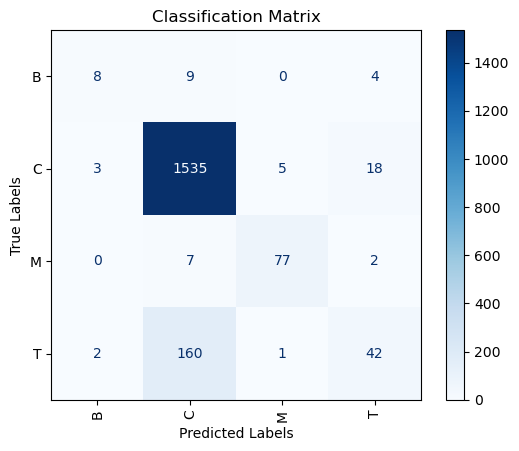

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.values())

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Classification Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### todo xgboost with only octave bands

### XGBoost with features: all

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, DMatrix

# Load the dataset
df = pd.read_csv(r"df_total_features.csv")

# Convert 'speed_kmh' to numeric and coerce errors to NaN
df['speed_kmh'] = pd.to_numeric(df['speed_kmh'], errors='coerce')

# Filter rows where 'vehicle' is valid and belongs to 'C', 'T', or 'B'
df = df[df['vehicle'].isin(['C', 'T', 'B'])]

# Remove rows with infinite or extremely large values in feature columns
features = [col for col in df.columns if col.startswith('mfcc_') or col.startswith('band_') or col.startswith('peak_')]
df[features] = df[features].replace([np.inf, -np.inf], np.nan)
df.dropna(subset=features, inplace=True)

# Extract features and target
X = df[features]
y = df['vehicle']

# Encode the target into numeric labels for multiclass classification
y_encoded = y.astype('category').cat.codes
label_mapping = dict(enumerate(y.astype('category').cat.categories))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Define the pipeline
pipeline = Pipeline([
    ('xgb', XGBClassifier(eval_metric='mlogloss'))  # Multiclass support
])

# Define a smaller parameter grid for GridSearchCV
param_grid = {
    'xgb__n_estimators': [100],             # Number of boosting rounds
    'xgb__learning_rate': [0.1, 0.3],       # Learning rate (eta)
    'xgb__max_depth': [3],                  # Maximum depth of trees
    'xgb__gamma': [0, 1],                   # Minimum loss reduction to split
    'xgb__reg_alpha': [0, 0.1],             # L1 regularization term
    'xgb__reg_lambda': [1, 1.5]             # L2 regularization term
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='f1_macro',   # Optimize for macro F1 score for multiclass
    verbose=1,
    n_jobs=-1             # Use all available CPUs
)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.values()))

# Save the label mapping
print("Label Mapping (Numeric to Vehicle):")
print(label_mapping)


/var/folders/vh/1t1ywg4n4fq7xwpclrv4jdyc0000gn/T/ipykernel_64737/1962735376.py:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"df_total_features.csv")
/Users/jakob/miniconda3/envs/seminar2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jakob/miniconda3/envs/seminar2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jakob/miniconda3/envs/seminar2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/jakob/miniconda3/envs/seminar2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jakob/miniconda3/envs/seminar2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jakob/miniconda3/envs/seminar2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jakob/miniconda3/envs/seminar2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best Parameters: {'xgb__gamma': 0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 1.5}
Classification Report:
              precision    recall  f1-score   support

           B       0.87      0.62      0.72        21
           C       0.91      0.98      0.95      1561
           T       0.68      0.31      0.43       205

    accuracy                           0.90      1787
   macro avg       0.82      0.64      0.70      1787
weighted avg       0.89      0.90      0.89      1787

Label Mapping (Numeric to Vehicle):
{0: 'B', 1: 'C', 2: 'T'}


### XGBoost with SMOTE to improve performance on minority classes

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

# Load the dataset
df = pd.read_csv(r"df_total_features.csv")

# Clean data
df['speed_kmh'] = pd.to_numeric(df['speed_kmh'], errors='coerce')

# Filter rows where 'vehicle' is valid and belongs to 'C', 'T', or 'B'
df = df[df['vehicle'].isin(['C', 'T', 'B'])]

# Extract features and target
features = [col for col in df.columns if col.startswith('mfcc_') or col.startswith('band_')]
X = df[features]
y = df['vehicle']

# Encode the target into numeric labels for multiclass classification
y_encoded = y.astype('category').cat.codes
label_mapping = dict(enumerate(y.astype('category').cat.categories))

# Replace infinities and NaN with 0
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# Validate dataset for invalid values
print(f"After cleaning - Contains NaN: {np.isnan(X).any()}")
print(f"After cleaning - Contains Inf: {np.isinf(X).any()}")

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Define the pipeline
pipeline = Pipeline([
    ('xgb', XGBClassifier(eval_metric='mlogloss', scale_pos_weight=None))  # Add class weighting if needed
])

# Define a parameter grid for GridSearchCV
param_grid = {
    'xgb__n_estimators': [100, 200],         # Number of boosting rounds
    'xgb__learning_rate': [0.1, 0.3],       # Learning rate (eta)
    'xgb__max_depth': [3, 5],               # Maximum depth of trees
    'xgb__gamma': [0, 1],                   # Minimum loss reduction to split
    'xgb__reg_alpha': [0, 0.1],             # L1 regularization term
    'xgb__reg_lambda': [1, 1.5],            # L2 regularization term
    'xgb__subsample': [0.8, 1],             # Subsampling ratio
    'xgb__min_child_weight': [1, 3]         # Minimum child weight
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='f1_macro',   # Optimize for macro F1 score for multiclass
    verbose=1,
    n_jobs=-1             # Use all available CPUs
)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.values()))

# Save the label mapping
print("Label Mapping (Numeric to Vehicle):")
print(label_mapping)


After cleaning - Contains NaN: mfcc_1        False
mfcc_2        False
mfcc_3        False
mfcc_4        False
mfcc_5        False
mfcc_6        False
mfcc_7        False
mfcc_8        False
mfcc_9        False
mfcc_10       False
mfcc_11       False
mfcc_12       False
mfcc_13       False
band_1_dB     False
band_2_dB     False
band_3_dB     False
band_4_dB     False
band_5_dB     False
band_6_dB     False
band_7_dB     False
band_8_dB     False
band_9_dB     False
band_10_dB    False
band_11_dB    False
band_12_dB    False
band_13_dB    False
band_14_dB    False
band_15_dB    False
band_16_dB    False
band_17_dB    False
band_18_dB    False
band_19_dB    False
band_20_dB    False
band_21_dB    False
band_22_dB    False
band_23_dB    False
band_24_dB    False
band_25_dB    False
band_26_dB    False
band_27_dB    False
band_28_dB    False
band_29_dB    False
dtype: bool
After cleaning - Contains Inf: mfcc_1        False
mfcc_2        False
mfcc_3        False
mfcc_4        False
mfcc_5

/var/folders/vh/1t1ywg4n4fq7xwpclrv4jdyc0000gn/T/ipykernel_64737/451324048.py:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"df_total_features.csv")
/var/folders/vh/1t1ywg4n4fq7xwpclrv4jdyc0000gn/T/ipykernel_64737/451324048.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/vh/1t1ywg4n4fq7xwpclrv4jdyc0000gn/T/ipykernel_64737/451324048.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Cross-Validation Scores (F1 Macro): [0.96181676 0.9633587  0.96179408 0.95531981 0.95165418]
Mean CV Score: 0.958788704788407
Standard Deviation of CV Score: 0.004517098637908747
Best Parameters: {'xgb__gamma': 0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 200, 'xgb__reg_alpha': 0.1, 'xgb__reg_lambda': 1, 'xgb__subsample': 0.8}
Classification Report:
              precision    recall  f1-score   support

           B       1.00      1.00      1.00      1561
           C       0.98      0.92      0.95      1561
           T       0.92      0.98      0.95      1561

    accuracy                           0.96      4683
   macro avg       0.97      0.96      0.96      4683
weighted avg       0.97      0.96      0.96      4683

Label Mapping (Numeric to Vehicle):
{0: 'B', 1: 'C', 2: 'T'}


In [12]:
from sklearn.model_selection import cross_val_score

# Use cross_val_score to evaluate the best model on the training data
cv_scores = cross_val_score(
    grid_search.best_estimator_,  # Best model from GridSearch
    X_train,                      # Training features
    y_train,                      # Training labels
    cv=5,                         # 5-fold cross-validation
    scoring='f1_macro',           # Use macro F1 score for multiclass
    n_jobs=-1                     # Use all available CPUs
)

# Output Cross-Validation Results
print("Cross-Validation Scores (F1 Macro):", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))
print("Standard Deviation of CV Score:", np.std(cv_scores))

Cross-Validation Scores (F1 Macro): [0.96181676 0.9633587  0.96179408 0.95531981 0.95165418]
Mean CV Score: 0.958788704788407
Standard Deviation of CV Score: 0.004517098637908747


These results suggest minimal risk of overfitting. Here's why:

- Cross-Validation Scores:
    - Mean F1 Macro: 0.9588, close to the test set's macro F1 score (0.96).
    - Low standard deviation (0.0045) across folds shows consistent performance on training data.

- Test Performance:
    - Test accuracy (0.96) and macro F1 (0.96) are comparable to cross-validation scores.
    - No significant drop-off between cross-validation and test metrics indicates good generalization.

- Class Performance:
    - While class B achieves perfect scores on the test set, classes C and T perform slightly lower, suggesting the model hasn't overfit to all classes.

Conclusion:

Your model performs consistently on the training and test sets, with no large discrepancies in metrics. This indicates it has generalized well, and overfitting is not a concern here.

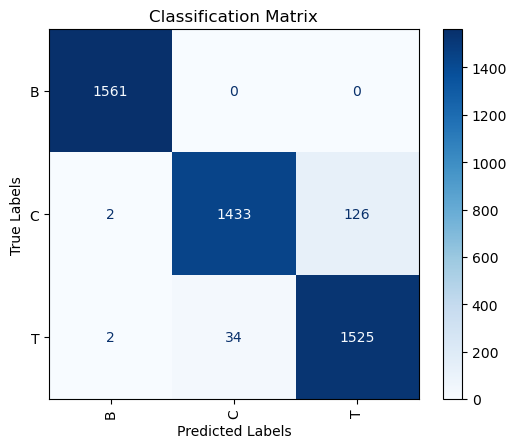

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.values())

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Classification Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Using class weights instead of SMOTE

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Load the dataset
df = pd.read_csv(r"df_total_features.csv")

# Convert 'speed_kmh' to numeric and coerce errors to NaN
df['speed_kmh'] = pd.to_numeric(df['speed_kmh'], errors='coerce')

# Filter rows where 'vehicle' is valid and belongs to 'C', 'T', or 'B'
df = df[df['vehicle'].isin(['C', 'T', 'B'])]

# Remove rows with infinite or extremely large values in feature columns
features = [col for col in df.columns if col.startswith('mfcc_') or col.startswith('band_') or col.startswith('peak_')]
df[features] = df[features].replace([np.inf, -np.inf], np.nan)
df.dropna(subset=features, inplace=True)

# Extract features and target
X = df[features]
y = df['vehicle']

# Encode the target into numeric labels for multiclass classification
y_encoded = y.astype('category').cat.codes
label_mapping = dict(enumerate(y.astype('category').cat.categories))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Compute class weights
class_weights = y.value_counts(normalize=True)
class_weights = {i: 1 / freq for i, freq in enumerate(class_weights)}

# Apply class weights to each class
sample_weights = y_train.map(lambda label: class_weights[label])

# Initialize XGBoost classifier
pipeline = Pipeline([
    ('xgb', XGBClassifier(eval_metric='mlogloss'))
])

# Define a parameter grid for GridSearchCV
param_grid = {
    'xgb__n_estimators': [100],
    'xgb__learning_rate': [0.1, 0.3],
    'xgb__max_depth': [3],
    'xgb__gamma': [0, 1],
    'xgb__reg_alpha': [0, 0.1],
    'xgb__reg_lambda': [1, 1.5],
    # Class weights are passed implicitly through sample weights
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_macro',  # Optimize for macro F1 score for multiclass
    verbose=1,
    n_jobs=-1
)

# Perform Grid Search with sample weights
grid_search.fit(X_train, y_train, xgb__sample_weight=sample_weights)

# Get the best parameters and model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.values()))

# Save the label mapping
print("Label Mapping (Numeric to Vehicle):")
print(label_mapping)


/var/folders/vh/1t1ywg4n4fq7xwpclrv4jdyc0000gn/T/ipykernel_64737/2842003441.py:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"df_total_features.csv")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'xgb__gamma': 0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 1}
Classification Report:
              precision    recall  f1-score   support

           B       0.90      0.43      0.58        21
           C       0.95      0.85      0.90      1561
           T       0.37      0.69      0.49       205

    accuracy                           0.83      1787
   macro avg       0.74      0.66      0.66      1787
weighted avg       0.89      0.83      0.85      1787

Label Mapping (Numeric to Vehicle):
{0: 'B', 1: 'C', 2: 'T'}


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Load the dataset
df = pd.read_csv(r"df_total_features.csv")

# Convert 'speed_kmh' to numeric and coerce errors to NaN
df['speed_kmh'] = pd.to_numeric(df['speed_kmh'], errors='coerce')

# Filter rows where 'vehicle' is valid and belongs to 'C', 'T', or 'B'
df = df[df['vehicle'].isin(['C', 'T', 'B'])]

# Remove rows with infinite or extremely large values in feature columns
features = [col for col in df.columns if col.startswith('mfcc_') or col.startswith('band_') or col.startswith('peak_')]
df[features] = df[features].replace([np.inf, -np.inf], np.nan)
df.dropna(subset=features, inplace=True)

# Add a binary column for "Car or Not"
df['is_car'] = df['vehicle'].apply(lambda x: 1 if x == 'C' else 0)

# Extract features for the first classification (Car or Not)
X = df[features]
y_car = df['is_car']

# Split data for the first classification
X_train, X_test, y_train_car, y_test_car = train_test_split(X, y_car, test_size=0.2, random_state=42, stratify=y_car)

# Compute scale_pos_weight for "Car or Not"
# Here, '1' = Car, so we compute ratio = (# of negatives) / (# of positives)
neg_count_car = np.sum(y_train_car == 0)
pos_count_car = np.sum(y_train_car == 1)
scale_pos_weight_car = neg_count_car / pos_count_car if pos_count_car != 0 else 1.0

# Train the "Car or Not" classifier
car_pipeline = Pipeline([
    ('xgb', XGBClassifier(eval_metric='logloss'))
])

param_grid_car = {
    'xgb__n_estimators': [100],
    'xgb__learning_rate': [0.1, 0.3],
    'xgb__max_depth': [3],
    'xgb__gamma': [0, 1],
    'xgb__reg_alpha': [0, 0.1],
    'xgb__reg_lambda': [1, 1.5],
    'xgb__scale_pos_weight': [scale_pos_weight_car]  # Use computed weight
}

car_grid_search = GridSearchCV(
    car_pipeline,
    param_grid_car,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

car_grid_search.fit(X_train, y_train_car)

# Evaluate "Car or Not" classifier
y_pred_car = car_grid_search.best_estimator_.predict(X_test)
print("Car or Not Classification Report:")
print(classification_report(y_test_car, y_pred_car))

# Filter data for "Bus or Truck" classification
df_bt = df[df['is_car'] == 0]
X_bt = df_bt[features]
y_bt = df_bt['vehicle'].apply(lambda x: 1 if x == 'B' else 0)  # Encode Bus as 1, Truck as 0

# Split data for "Bus or Truck" classification
X_train_bt, X_test_bt, y_train_bt, y_test_bt = train_test_split(X_bt, y_bt, test_size=0.2, random_state=42, stratify=y_bt)

# Compute scale_pos_weight for "Bus or Truck"
# Here, '1' = Bus, so ratio = (# of Truck) / (# of Bus)
neg_count_bt = np.sum(y_train_bt == 0)
pos_count_bt = np.sum(y_train_bt == 1)
scale_pos_weight_bt = neg_count_bt / pos_count_bt if pos_count_bt != 0 else 1.0

# Train the "Bus or Truck" classifier
bt_pipeline = Pipeline([
    ('xgb', XGBClassifier(eval_metric='logloss'))
])

param_grid_bt = {
    'xgb__n_estimators': [100],
    'xgb__learning_rate': [0.1, 0.3],
    'xgb__max_depth': [3],
    'xgb__gamma': [0, 1],
    'xgb__reg_alpha': [0, 0.1],
    'xgb__reg_lambda': [1, 1.5],
    'xgb__scale_pos_weight': [scale_pos_weight_bt]  # Use computed weight
}

bt_grid_search = GridSearchCV(
    bt_pipeline,
    param_grid_bt,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

bt_grid_search.fit(X_train_bt, y_train_bt)

# Evaluate "Bus or Truck" classifier
y_pred_bt = bt_grid_search.best_estimator_.predict(X_test_bt)
print("Bus or Truck Classification Report:")
print(classification_report(y_test_bt, y_pred_bt, target_names=['Truck', 'Bus']))


/var/folders/vh/1t1ywg4n4fq7xwpclrv4jdyc0000gn/T/ipykernel_64737/1580097796.py:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"df_total_features.csv")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Car or Not Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.69      0.56       226
           1       0.95      0.89      0.92      1561

    accuracy                           0.86      1787
   macro avg       0.71      0.79      0.74      1787
weighted avg       0.89      0.86      0.87      1787

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Bus or Truck Classification Report:
              precision    recall  f1-score   support

       Truck       0.97      0.99      0.98       205
         Bus       0.88      0.71      0.79        21

    accuracy                           0.96       226
   macro avg       0.93      0.85      0.89       226
weighted avg       0.96      0.96      0.96       226



In [17]:
from sklearn.metrics import f1_score

# Combine predictions from "Car or Not" and "Bus or Truck"
y_true_combined = []
y_pred_combined = []

# Track index for "Not Car" samples
not_car_index = 0

for i in range(len(y_test_car)):
    if y_test_car.iloc[i] == 1:  # True "Car"
        y_true_combined.append(1)  # Car = 1
        y_pred_combined.append(y_pred_car[i])  # Predicted "Car"
    else:  # Not Car
        # Ensure index alignment for "Bus or Truck"
        y_true_combined.append(2 if y_test_bt.iloc[not_car_index] == 0 else 3)  # Truck = 2, Bus = 3
        y_pred_combined.append(2 if y_pred_bt[not_car_index] == 0 else 3)  # Predicted Truck/Bus
        not_car_index += 1  # Increment the "Not Car" index

# Calculate the overall F1 Macro score
overall_f1_macro = f1_score(y_true_combined, y_pred_combined, average='macro')
print("Overall F1 Macro Average:", overall_f1_macro)


Overall F1 Macro Average: 0.6780508884713564
